# Machine Learning hand-in 4
This handin is about implementing and using representative-based clustering algorithms. If you have made your way through the programming exercises for weeks 11 and 12 you are almost done with the first two parts of the handin. 

The handin is mandatory, and should be done in groups of 2-3 students. Each group
must prepare a report in PDF format as outlined below. Please submit all your
Python files in a zip file, and your PDF report outside the zip file, to
Blackboard no later than **Friday, December 8 at 9:00 AM**.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 1. Implementing the Algorithms
In this section you must implement Lloyds algorithm andthe Gaussian Mixture Expectation
Maximization algorithm. Please refer to p. 349 and p. 335 of the textbook [ZM] or see the exercises from <a href="https://github.com/AlexanderMath/MLNotebooks/blob/master/AU%20ML%20course/Week%2011.ipynb" target="new">week 11</a>/12. If you already did this during class copy paste them in below. Like in class, you should test your algorithms on the Iris data set:

<!-- 
For the EM algorithm, you may use the `pdf` function below to compute the probability
densities in the Gaussian Mixture model.

You should use the Python code displayed previously to load and display Iris data
and apply PCA to reduce it from four dimensions to two.

Use the 2d Iris data to validate your algorithms (compare the results you get
with the results in the textbook on the same data), and run your algorithms on
the 4d data and compare.

You should read the deliverables section at the very end of the notebook before getting into detail with the code below.-->

In [15]:
# Load the Iris data set
import sklearn.datasets
X,y = sklearn.datasets.load_iris(True)
X = iris['data'][:,0:2] # reduce to 2d so you can plot if you want

### 1.1 Lloyd's Algorithm
You are allowed to structure your code however you want. The template below is identical to the one given in class at <a href="https://github.com/AlexanderMath/MLNotebooks/blob/master/AU%20ML%20course/Week%2011.ipynb" target="new">week 11</a>. We recommend you use it. 

In [3]:
def lloyds_algorithm(X, k, T):
    """ Clusters the data of X into k clusters using T iterations of Lloyd's algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations to run Lloyd's algorithm. 
        
        Returns
        -------
        clustering: A vector of shape (n, ) where the i'th entry holds the cluster of X[i].
        centroids:  The centroids/average points of each cluster. 
        cost:       The cost of the clustering 
    """
    n, d = X.shape
    
    # Initialize clusters random. 
    clustering = np.random.randint(0, k, (n, )) 
    centroids  = np.zeros((k, d))
    
    # Used to stop if cost isn't improving (decreasing)
    cost = 0
    oldcost = 0
    
    # Column names
    print("Iterations\tCost")
    
    for i in range(T):
        # Update centroid
        for cent in range (k):
            if len(X[clustering==cent,])!=0:
                centroids[cent,]=sum(X[clustering==cent,])/len(X[clustering==cent,])
        
        # Update clustering 
        for point in range(n):
            dist = np.zeros(k)
            for cluster in range(k):
#                dist[cluster]=sum(np.square(X[point,]-centroids[cluster,]))
                dist[cluster]=np.linalg.norm(X[point] - centroids[cluster])**2
            clustering[point]=np.argmin(dist)
        
        # Compute and print cost
        cost = 0
        for j in range(n):
            cost += np.linalg.norm(X[j] - centroids[clustering[j]])**2    
        print(i+1, "\t\t", cost)
        
        # Stop if cost didn't improve more than epislon (decrease)
        if np.isclose(cost, oldcost): break #TODO
        oldcost = cost
        
    return clustering, centroids, cost

clustering, centroids, cost = lloyds_algorithm(X, 3, 100)

Iterations	Cost
1 		 112.694951972
2 		 41.5582265849
3 		 38.8611189236
4 		 38.1209903243
5 		 37.6950330377
6 		 37.3284357139
7 		 37.1362607146
8 		 37.1237021277
9 		 37.1237021277


### 1.2 Expectation Maximization Algorithm
Again, you are allowed to structure your code however you want. The template below (and the helper function `compute_probs_cx`) is identical to the one given in class at <a href="https://github.com/AlexanderMath/MLNotebooks/blob/master/AU%20ML%20course/Week-12.ipynb" target="new">week 12</a>. We recommend you use it. 

In [4]:
import numpy as np
from scipy.stats import multivariate_normal

def compute_probs_cx(points, means, covs, probs_c):
    '''
    Input
      - points: (n times d) array containing the dataset
      - means:  (k times d) array containing the k means
      - covs:   (k times d times d) array such that cov[j,:,:] is the covariance matrix of the j-th Gaussian.
      - priors: (k) array containing priors
    Output
      - probs:  (k times n) array such that the entry (i,j) represents Pr(C_i|x_j)
    '''
    # Convert to numpy arrays.
    points, means, covs, probs_c = np.asarray(points), np.asarray(means), np.asarray(covs), np.asarray(probs_c)
    
    # Get sizes
    n, d = points.shape
    k = means.shape[0]
    
    # Compute probabilities
    # This will be a (k, n) matrix where the (i,j)'th entry is Pr(C_i)*Pr(x_j|C_i).
    probs_cx = np.zeros((k, n))
    for i in range(k):
        try:
            probs_cx[i] = probs_c[i] * multivariate_normal.pdf(mean=means[i], cov=covs[i], x=points)
        except Exception as e:
            print("Cov matrix got singular: ", e)
    
    # The sum of the j'th column of this matrix is P(x_j); why?
    probs_x = np.sum(probs_cx, axis=0, keepdims=True) 
    assert probs_x.shape == (1, n)
    
    # Divide the j'th column by P(x_j). The the (i,j)'th then 
    # becomes Pr(C_i)*Pr(x_j)|C_i)/Pr(x_j) = Pr(C_i|x_j)
    probs_cx = probs_cx / probs_x
    
    return probs_cx, probs_x

In [5]:
def em_algorithm(X, k, T, epsilon = 0.001, means=None):
    """ Clusters the data X into k clusters using the Expectation Maximization algorithm. 
    
        Parameters
        ----------
        X : Data matrix of shape (n, d)
        k : Number of clusters.
        T : Maximum number of iterations
        epsilon :  Stopping criteria for the EM algorithm. Stops if the means of
                   two consequtive iterations are less than epsilon.
        means : (k times d) array containing the k initial means (optional)
        
        Returns
        -------
        means:     (k, d) array containing the k means
        covs:      (k, d, d) array such that cov[j,:,:] is the covariance matrix of 
                   the Gaussian of the j-th cluster
        probs_c:   (k, ) containing the probability Pr[C_i] for i=0,...,k. 
        llh:       The log-likelihood of the clustering (this is the objective we want to maximize)
    """
    n, d = X.shape
    
    # Initialize and validate mean
    if means is None: 
        means = np.random.rand(k, d)

    # Initialize cov, prior
    probs_x  = np.zeros(n) 
    probs_cx = np.zeros((k, n)) 
    probs_c  = np.zeros(k) + np.random.rand(k)
    
    covs = np.zeros((k, d, d))
    for i in range(k): covs[i] = np.identity(d)
    probs_c = np.ones(k) / k
    
    # Column names
    print("Iterations\tLLH")
    
    close = False
    old_means = np.zeros_like(means)
    iterations = 0
    while not(close) and iterations < T:
        old_means[:] = means 

        # Expectation step
        probs_cx, probs_x = compute_probs_cx(X, means, covs, probs_c)
        assert probs_cx.shape == (k, n)

        # YOUR CODE HERE
        for i in range(k):
            probs_c[i] = np.sum(probs_cx[i])/n
            
            means[i] = np.dot(probs_cx[i],X)/np.sum(probs_cx[i])
            weighted_sum = sum(probs_cx[i,j] * np.outer(X[j] - means[i],X[j] - means[i]) for j in range(n))
            denom = np.sum(probs_cx[i])
            
            covs[i] = np.array(weighted_sum/denom)
        
        # Compute per-sample average log likelihood (llh) of this iteration     
        llh = 1/n*np.sum(np.log(probs_x))
        print(iterations+1, "\t\t", llh)

        # Stop condition
        dist = np.sqrt(((means - old_means) ** 2).sum(axis=1))
        close = np.all(dist < epsilon)
        iterations += 1
        
    # Validate output
    assert means.shape == (k, d)
    assert covs.shape == (k, d, d)
    assert probs_c.shape == (k,)
    
    return means, covs, probs_c, llh

If one wants a hard clustering where each point belongs strictly to one cluster, one could assign each point to the cluster that maximize $\Pr(C_i \mid x)$ for $i=1,..,k$. The following function does that.

In [7]:
def compute_em_cluster(means, covs, probs_c, data):
    probs_cx, probs_c = compute_probs_cx(data, means, covs, probs_c)
    clustering = probs_cx.argmax(axis=0)
    return clustering

## 1.3: Combine Lloyd's algorithm with the Expectation Maximization algorithm 
In order to determine an initial set of cluster centers for the EM algorithm, one can utilize the best centroids determined by Lloyd's algorithm. For this, run Lloyd's algorithm several times, and choose the best one. Then run the EM algorithm with the initial means as the centroids obtained in the previous step.

Test your implementation on the Iris dataset. Compare the results with Lloyd's Algorithm and the Expectation Maximization algorithm (without Lloyd's initialization). You could compare the clusterings by visualizing them like we did in class, or by using the evaluation measure from the next section. 

In [8]:
# Load the Iris data set
import sklearn.datasets
iris = sklearn.datasets.load_iris()
X = iris['data'][:,0:2] # reduce to 2d so you can plot if you want

clustering, centroids, cost = lloyds_algorithm(X, 3, 100)
print(clustering)
k = 3
T = 100
means, covs, probs_c, llh = em_algorithm(X, k, T, epsilon = 0.001, means=centroids)
cluster = compute_em_cluster(means, covs, probs_c, X)
print(cluster)


Iterations	Cost
1 		 117.547015817
2 		 52.9417805901
3 		 48.8521590952
4 		 47.3880414849
5 		 45.8475676828
6 		 44.6573599911
7 		 44.3848550347
8 		 43.5914976201
9 		 41.9049282287
10 		 39.0665135416
11 		 38.3164999092
12 		 37.9125362103
13 		 37.4233063452
14 		 37.1362607146
15 		 37.1237021277
16 		 37.1237021277
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 1]
Iterations	LLH
1 		 -2.4082012188
2 		 -1.76876103428
3 		 -1.74162145633
4 		 -1.71327627521
5 		 -1.68623316708
6 		 -1.66486500003
7 		 -1.64670681668
8 		 -1.62646914377
9 		 -1.60058649714
10 		 -1.56694614037
11 		 -1.52986098036
12 		 -1.50441380602
13 		 -1.49471832989
14 		 -1.49124090729
15 		 -1.48913287538
16 		 -1.48754696497
17 		 -1.48627444667
18 		

Conclusion:
I compared the performance of both algorithms using silhouette coefficient and F1-score as-well. And based on these, I found that Llyod’s algorithm gave better results compared to Expectation Maximization. But this is not what I expected to see. I expected the Expectation maximization algorithm to perform better.

## 2. Evaluating clusterings

Implement the F1 score (build the contingency table p. 426, measure pp. 427-428)
and the silhouette coefficient (pp. 444-445), and compare the quality of
several runs of your algorithms with different values for *k*. 

You will need labels to compute the F1 score. These are imported below

In [ ]:
# Load the Iris data set
import sklearn.datasets
X, y = sklearn.datasets.load_iris(True)
X = X[:,0:2] # reduce to 2d so you can plot if you want
print(X.shape, y.shape)

## 2.1 Silhouette Coefficient
Implement the Silhouette coefficient as explained during the lectures and class week 11 and 12. Explanations can be found both on slides and in the book. You can use the following template

In [9]:
def silhouette(data, clustering): 
    n, d = data.shape
    k = np.unique(clustering)[-1]+1

    silh = np.zeros(n)

    for point in range(n):
        cohesion = 0
        separation = []
        for j in range(n):
            if clustering[point]==clustering[j] and point!=j:
                cohesion += np.linalg.norm(data[point]-data[j])
        cohesion = cohesion/(np.count_nonzero(clustering==clustering[point])-1)
        for cent in range(k):
            if cent != clustering[point]:
                s = 0
                for j in range(n):
                    if clustering[j] == cent:
                        s+=np.linalg.norm(data[point]-data[j])
                separation.append(s)
        silh[point]=(min(separation)-cohesion)/max(min(separation),cohesion)

    return silh

Try to run Lloyd's algorithm and the Expectation Maximization algorithm with different $k$ and compute the silhouette coefficient for each. You could use the following template

In [11]:
for k in range(2, 10):
    clustering, centroids, cost = lloyds_algorithm(X, k, 50)
    lloyd_sc = np.mean(silhouette(X, clustering))
    print("LLoyd:", k, lloyd_sc)

    means, covs, probs, llh = em_algorithm(X, k, 100, epsilon = 0.001, means = centroids)    
    clustering = compute_em_cluster(means, covs, probs, X)    
    em_score = np.mean(silhouette(X,clustering))
    print("EM:", k, em_score)

Iterations	Cost
1 		 120.542433558
2 		 59.1063784121
3 		 58.3432135748
4 		 58.2631330014
5 		 58.2631330014
LLoyd: 2 0.992865459996
Iterations	LLH
1 		 -2.36452611454
2 		 -1.77269847381
3 		 -1.74817621279
4 		 -1.72420435433
5 		 -1.70113874438
6 		 -1.67900089299
7 		 -1.66259969899
8 		 -1.65239580362
9 		 -1.64346525349
10 		 -1.63322504299
11 		 -1.62037471696
12 		 -1.60347277204
13 		 -1.58050694944
14 		 -1.55082637938
15 		 -1.52247485597
16 		 -1.50902417712
17 		 -1.50688451963
18 		 -1.50675329833
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
EM: 2 0.9900107997
Iterations	Cost
1 		 118.416255093
2 		 45.6414817116
3 		 39.9751470314
4 		 38.4237616536
5 		 37.9125362103
6 		 37.4233063452
7 		 37.1362607146
8 		 37

18 		 -1.43449822458
19 		 -1.4225559475
20 		 -1.4115700487
21 		 -1.4039417673
22 		 -1.39944942283
23 		 -1.3967786774
24 		 -1.39499384533
25 		 -1.39360313214
26 		 -1.39235883302
27 		 -1.39110884394
28 		 -1.38971747832
29 		 -1.38802176761
30 		 -1.38581289984
31 		 -1.3829370893
32 		 -1.37955706706
33 		 -1.37567161146
34 		 -1.37082434988
35 		 -1.36501308323
36 		 -1.35915899704
37 		 -1.35412934463
38 		 -1.34981509841
39 		 -1.34572042838
40 		 -1.34137964057
41 		 -1.3367334999
42 		 -1.33383193098
43 		 -1.33241892875
44 		 -1.33152346187
45 		 -1.33082644389
46 		 -1.33019805281
47 		 -1.32955854978
48 		 -1.32882853442
49 		 -1.3279077304
50 		 -1.32664782837
51 		 -1.32480712068
52 		 -1.32201509239
53 		 -1.31806226863
54 		 -1.31421888386
55 		 -1.31232708471
56 		 -1.31142187979
57 		 -1.31062447542
58 		 -1.30969457587
59 		 -1.30851773073
60 		 -1.30703990757
61 		 -1.30536438776
62 		 -1.3038800367
63 		 -1.30294498298
64 		 -1.30238297746
65 		 -1.3019137842
6

/Users/Noor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/Users/Noor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less


Conclusion:
Both Llyod’s algorithm and expectation maximization algorithm gave the best silhouette coefficient at k = 2.

## 2.1 F1 Score
Implement a function that compute the F1 score. There are explanations in the slides and in the book. You can use the following template

In [12]:
def f1(predicted, labels):
    n, = predicted.shape
    assert labels.shape == (n,)
    r = np.max(predicted) + 1
    k = np.max(labels) + 1

    # Implement the F1 score here
    # YOUR CODE HERE
    contingency = np.zeros((r,k))
    F_individual = np.zeros(r)
    F_overall = None
    for i in range(n):
        contingency[predicted[i],labels[i]]+=1
    precision = np.zeros(r)
    recall = np.zeros(r)
    for i in range(r):
        precision[i] = np.max(contingency[i,])/np.sum(contingency[i,])
        recall[i] = np.max(contingency[i,])/np.sum(contingency[:,np.argmax(contingency[i])])
        F_individual[i] = 2*precision[i]*recall[i]/(precision[i]+recall[i])
    # END CODE

    assert contingency.shape == (r, k)
    return F_individual, F_overall, contingency

Make a similar experiment as the one for the silhouette coefficient. In other words: try to run Lloyd's algorithm and the Expectation Maximization algorithm with different k and compute the F1 score for each. You could use the following template

In [17]:
for k in range(2, 10):
    clustering, centroids, cost = lloyds_algorithm(X, k, 50)
    lloyd_sc = f1(clustering,y)
    print(k, lloyd_sc[1])

    means, covs, probs, llh = em_algorithm(X, k, 100, epsilon = 0.001, means = centroids)    
    clustering = compute_em_cluster(means, covs, probs, X)    
    em_sc = f1(clustering,y)
    print("EM:", k, em_sc[1]) 

Iterations	Cost
1 		 106.630593939
2 		 59.4389107143
3 		 58.0100828125
4 		 57.9964787976
5 		 57.9964787976
2 None
Iterations	LLH
1 		 -2.36586460507
2 		 -1.77280441965
3 		 -1.74836704568
4 		 -1.72412936382
5 		 -1.70075703014
6 		 -1.67917486459
7 		 -1.6643583971
8 		 -1.65540169345
9 		 -1.64747479905
10 		 -1.63839846234
11 		 -1.62710777803
12 		 -1.6124846727
13 		 -1.59284387613
14 		 -1.56630487584
15 		 -1.53551695852
16 		 -1.51359806531
17 		 -1.50734846227
18 		 -1.50677776273
19 		 -1.50674743945
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
EM: 2 None
Iterations	Cost
1 		 95.187106102
2 		 42.4372129946
3 		 37.5964114724
4 		 37.2578859366
5 		 37.2293371267
6 		 37.2013020414
7 		 37.155047785
8 		 37.1411722

/Users/Noor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/Users/Noor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in less


67 		 -1.34217245661
68 		 -1.3421595493
69 		 -1.3421486666
70 		 -1.34213952405
71 		 -1.34213186589
72 		 -1.34212546538
73 		 -1.34212012393
74 		 -1.34211566947
[4 1 4 4 4 1 4 4 4 4 4 4 1 4 4 1 1 4 4 1 4 1 4 4 4 4 4 4 4 4 4 4 1 1 4 4 4
 4 4 4 4 5 4 4 1 1 1 4 1 4 6 6 6 0 3 3 6 5 3 2 0 3 2 3 3 6 3 3 2 2 3 3 2 3
 3 3 3 6 3 2 0 0 3 3 3 6 6 2 3 2 2 3 2 5 3 3 3 3 5 3 6 3 6 3 3 6 5 6 2 0 6
 3 6 2 3 6 3 0 6 2 6 3 6 3 6 6 3 3 3 6 6 0 3 3 2 6 6 6 3 6 6 6 3 6 6 6 2 3
 6 3]
EM: 7 None
Iterations	Cost
1 		 85.7336318114
2 		 28.5700794137
3 		 21.763304741
4 		 17.7755072977
5 		 15.8629657881
6 		 14.7967600323
7 		 14.233920836
8 		 13.8345848422
9 		 13.689258585
10 		 13.6463419471
11 		 13.6463419471
8 None
Iterations	LLH
1 		 -2.47557777722
2 		 -1.76774998021
3 		 -1.74020896474
4 		 -1.71123044259
5 		 -1.68108641195
6 		 -1.64914234264
7 		 -1.61456271959
8 		 -1.57463939612
9 		 -1.53151781607
10 		 -1.49928705408
11 		 -1.48251751034
12 		 -1.47341859212
13 		 -1.46664158154
14 		 -

/Users/Noor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


<b>Conclusion: </b>
Llyod’s algorithm gave the best F1-score at k= 3 whereas, expectation maximization algorithm gave the highest F1-score at k = 2.


# 3. Compressing images
In class week 11 you saw how to do image compression using clustering. In this section you will revisit image compression. Find a picture you like. You could Google your favourite animal, car, disney cartoon character or take a photo of your study group. You should now use Lloyd's algorithm, EM or a combination to compress your image. 

The size of images can be measured in bytes. The following code downloads an image, displays it and prints the size of the images in bytes:

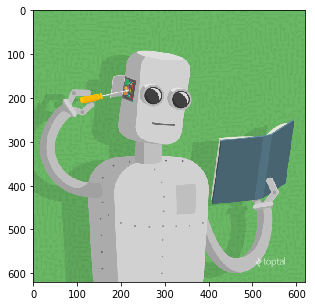

The image consumes a total of 106292 bytes. 

You should compress your image as much as possible! 


In [18]:
import scipy.misc
import matplotlib.pyplot as plt
import os

def download_image(url):
    filename = url[url.rindex('/')+1:]
    try:
        with open(filename, 'rb') as fp:
            return scipy.misc.imread(fp) / 255
    except FileNotFoundError:
        import urllib.request
        with open(filename, 'w+b') as fp, urllib.request.urlopen(url) as r:
            fp.write(r.read())
            return scipy.misc.imread(fp) / 255
 
img_facade = download_image('https://uploads.toptal.io/blog/image/443/toptal-blog-image-1407508081138.png')

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(img_facade)
plt.show()

size = os.stat('toptal-blog-image-1407508081138.png').st_size

print("The image consumes a total of %i bytes. \n"%size)
print("You should compress your image as much as possible! ")

The following code downloads an image of the Nygaard building and attempts to compress it with Lloyd's algorithm as we did in class. It then saves the compressed version, prints the size of the original and the compressed version; it finally prints the compression ratio.  

Modify the code such that it compresses your image; <font color="red">you should get a compression ratio of at least 1.5</font>!

Iterations	Cost
1 		 75286.9720919
2 		 15199.6495202
3 		 11424.8506794
4 		 10433.4651043
5 		 9829.6484631


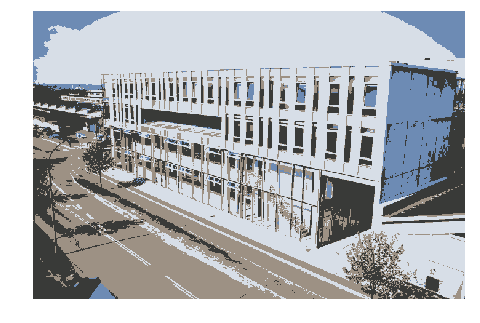

Original Size: 		 127983
Compressed Size: 	 71433
Compression Ratio: 	 1.79165


In [19]:
import os
import numpy as np

def compress_kmeans(im, k, T, name):
    height, width, depth = im.shape
    data = im.reshape((height * width, depth))
    clustering, centroids, score = lloyds_algorithm(data, k, 5)
    
    # make each entry of data to the value of it's cluster
    data_compressed = data
    
    for i in range(k): data_compressed[clustering == i] = centroids[i] 
    
    im_compressed = data_compressed.reshape((height, width, depth))
    
    # The following code should not be changed. 
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(im_compressed)
    plt.savefig("compressed.jpg")
    plt.show()
    
    original_size   = os.stat(name).st_size
    compressed_size = os.stat('compressed.jpg').st_size
    print("Original Size: \t\t", original_size)
    print("Compressed Size: \t", compressed_size)
    print("Compression Ratio: \t", round(original_size/compressed_size, 5))

def compress_facade(k=4, T=100):
    img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
    compress_kmeans(img_facade, k, T, 'nygaard_facade.jpg')
    
compress_facade()

<b>Conclusion: </b>
The compression ratio acheived using Llyod's algorithm is 1.79165 which is greater than 1.5 which is what we were aiming for.

# 4. Sampling from MNIST
The code below runs `sklearn`'s implementation of EM on the MNIST dataset. It then prints the clusters which should look like digits. Because the clusters are represented as gaussians we can sample from them. There is a function called `sample_digits` below which can sample digits. 

Try run the code

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Initialization 0
  Iteration 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
  Iteration 20
  Iteration 21
  Iteration 22
  Iteration 23
  Iteration 24
  Iteration 25
  Iteration 26
  Iteration 27
  Iteration 28
  Iteration 29
  Iteration 30
  Iteration 31
  Iteration 32
  Iteration 33
  Iteration 34
  Iteration 35
  Iteration 36
  Iteration 37
  Iteration 38
  Iteration 39
  Iteration 40
  Iteration 41
  Iteration 42
  Iteration 43
  Iteration 44
  Iteration 45
  Iteration 46
  Iteration 47
  Iteration 48
Initialization converged: True


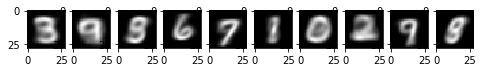

In [22]:
import tensorflow as tf
from sklearn.mixture import GaussianMixture as EM
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

X = mnist.train.images
y = mnist.train.labels

# One cluster for each digit
k = 10

# Run EM algorithm on 1000 images from the MNIST dataset. 
expectation_maximization = EM(n_components=k, max_iter=100, init_params='kmeans', covariance_type='diag', verbose=1, verbose_interval =1).fit(X)

means = expectation_maximization.means_
covs = expectation_maximization.covariances_
      
fig, ax = plt.subplots(1, k, figsize=(8, 1))

for i in range(k):
    ax[i].imshow(means[i].reshape(28, 28), cmap='gray')
    
plt.show()


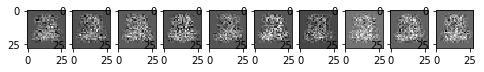

In [21]:
from scipy.stats import multivariate_normal
import numpy as np

def sample(means, covs, num):
    mean = means[num]
    cov = covs[num]
     
    fig, ax = plt.subplots(1, 10, figsize=(8, 1))
    
    for i in range(10):
        img = multivariate_normal.rvs(mean=mean, cov=cov) # draw random sample   
        ax[i].imshow(img.reshape(28, 28), cmap='gray') # draw the random sample
    plt.show()
    
sample(means, covs, 0)

<b>Conclusion: </b>
One can generate images of "digits" using the Expectation Maximization algorithm because each image is just a data point with 784 dimensions, we can just partition them into 10 clusters using EM algorithm, and a mean of each cluster should resemble a number after reshaping and generating an image. 